In [1]:
%pylab inline
import requests, zipfile
import StringIO
import datetime
import pandas as pd
import numpy as np
from workflow.data import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
# find csv file for tripdata
year = 2017
month = 3
#csvPath = '{}{:02}-citibike-tripdata.csv'.format(year, month)
#df = pd.read_csv(basepath + csvPath, parse_dates = ['Start Time', 'Stop Time'])
df = trip_data(year, month)
df['trip_id'] = df.index.values
df = df[df.stop_lat != 0]

In [3]:
#load stations.csv or create a stations df from tripdata
import os
if os.path.exists('stations.csv'):
    stations = pd.read_csv('stations.csv', index_col='id')
else:    
    stations = stations_from_trips(df)
    
stations.head()

,name,lat,long
id,,,
72,W 52 St & 11 Ave,40.767272,-73.993929
79,Franklin St & W Broadway,40.719116,-74.006667
82,St James Pl & Pearl St,40.711174,-74.000165
83,Atlantic Ave & Fort Greene Pl,40.683826,-73.976323
116,W 17 St & 8 Ave,40.741776,-74.001497


## Interesting stats

In [5]:
print "Total trips for {}-{:02}: {}".format(year, month, df.shape[0])

Total trips for 2017-03: 727664


In [6]:
sub_trips = df[df.user_type == 'Subscriber'].shape[0] / float(df.shape[0])
print "% subscribers: {:.3f}".format(100*sub_trips)

% subscribers: 95.614


In [7]:
male_trips = df[df.gender == 1].shape[0] / float(df.shape[0])
female_trips = df[df.gender == 2].shape[0] / float(df.shape[0])# add a column called trip_id within
print "% Male trips: {:.3f}".format(100*male_trips)
print "% Female trips: {:.3f}".format(100*female_trips)
print "% other trips: {:.3f}".format(100*(1 - male_trips - female_trips))

% Male trips: 74.038
% Female trips: 21.091
% other trips: 4.870


In [8]:
# top 10 starting locations
top_starts = df.groupby(['start_name', 'start_lat', 'start_long']).count().duration.sort_values(ascending = False)
top_starts = top_starts.reset_index()
top_starts.head()

,start_name,start_lat,start_long,duration
0,Pershing Square North,40.751873,-73.977706,9076
1,E 17 St & Broadway,40.737050,-73.990093,5443
2,W 21 St & 6 Ave,40.741740,-73.994156,5305
3,W 33 St & 7 Ave,40.750200,-73.990931,5293
4,Broadway & E 22 St,40.740343,-73.989551,5173


In [9]:
# top 10 stopping locations
top_stops = df.groupby(['stop_name', 'stop_lat', 'stop_long']).count().duration.sort_values(ascending = False)
top_stops = top_stops.reset_index()
top_stops.head()

,stop_name,stop_lat,stop_long,duration
0,Pershing Square North,40.751873,-73.977706,9014
1,W 33 St & 7 Ave,40.750200,-73.990931,6312
2,E 17 St & Broadway,40.737050,-73.990093,5894
3,Broadway & E 22 St,40.740343,-73.989551,5608
4,W 21 St & 6 Ave,40.741740,-73.994156,5375


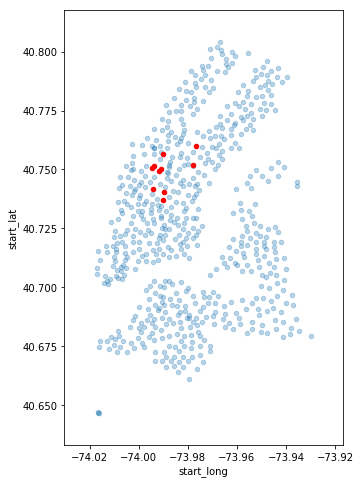

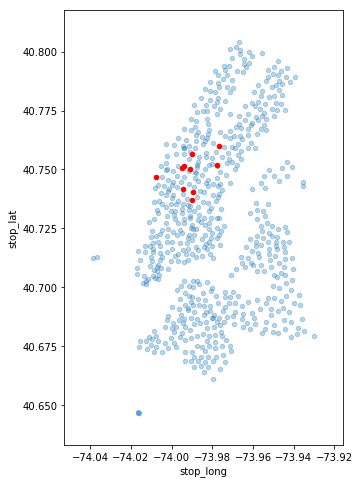

In [12]:
def plot_top_stations(df, x_values, y_values):
    pl = df.plot(kind = 'scatter', x = x_values, y = y_values, 
                alpha = 0.3, figsize = (5,8))
    df.head(10).reset_index().plot(kind = 'scatter', x = x_values,
                 color = 'r', y = y_values, ax = pl)

plot_top_stations(top_starts, 'start_long', 'start_lat')
plot_top_stations(top_stops, 'stop_long', 'stop_lat')

## Rebalancing

In [13]:
oneday = df[(df.start_time.dt.day == 1) & (df.start_time.dt.month == 3)]

In [14]:
bike_list = df.bike_id.unique()

# collect rebal events for the first 100 bikes
df = df.sort_values(['bike_id', 'start_time'])
#cols = ['start_id','stop_id', 'start_time', 'stop_time', 'bike_id']
df1 = df[df.bike_id.isin(bike_list[:100])]

# track rebalancing events 
#(REMEMBER THAT REBAL EVENTS USE STOP_TIME AS THE STARTING TIME)

shift_cols = ['stop_id','stop_time', 'stop_long', 'stop_lat', 'stop_name']

def shift_cond(bike_df):
    bike_df[shift_cols] = bike_df[shift_cols].shift(1)
    return bike_df[bike_df.start_id != bike_df.stop_id]

rebal_df = df1.groupby('bike_id').apply(shift_cond).dropna()
rebal_df.index = rebal_df.index.droplevel('bike_id')
rebal_df

,duration,start_time,stop_time,start_id,start_name,start_lat,start_long,stop_id,stop_name,stop_lat,stop_long,bike_id,user_type,birth_year,gender,trip_id
45498,381,2017-03-02 08:08:33,2017-03-01 22:14:18,3163,Central Park West & W 68 St,40.773407,-73.977825,434.0,9 Ave & W 18 St,40.743174,-74.003664,14891,Subscriber,1991.0,2,45498
220087,303,2017-03-08 13:56:09,2017-03-07 08:41:32,3144,E 81 St & Park Ave,40.776777,-73.959010,3443.0,W 52 St & 6 Ave,40.761330,-73.979820,14891,Subscriber,1959.0,2,220087
261270,478,2017-03-09 11:40:40,2017-03-09 08:12:49,258,DeKalb Ave & Vanderbilt Ave,40.689407,-73.968855,324.0,DeKalb Ave & Hudson Ave,40.689888,-73.981013,14891,Subscriber,1961.0,1,261270
713523,724,2017-03-30 18:46:03,2017-03-13 15:29:03,3134,3 Ave & E 62 St,40.763126,-73.965269,3399.0,7 St & 3 Ave,40.672603,-73.989830,14891,Subscriber,1959.0,2,713523
47764,436,2017-03-02 08:41:23,2017-03-01 20:12:48,432,E 7 St & Avenue A,40.726218,-73.983799,511.0,E 14 St & Avenue B,40.729387,-73.977724,14899,Subscriber,1967.0,1,47764
456458,618,2017-03-22 08:46:35,2017-03-13 15:37:24,445,E 10 St & Avenue A,40.727408,-73.981420,3083.0,Bushwick Ave & Powers St,40.712477,-73.941000,14899,Subscriber,1985.0,1,456458
520065,1006,2017-03-24 12:36:30,2017-03-24 09:07:29,487,E 20 St & FDR Drive,40.733143,-73.975739,503.0,E 20 St & Park Ave,40.738274,-73.987520,14899,Subscriber,1990.0,1,520065
698720,372,2017-03-30 13:34:54,2017-03-29 18:11:32,504,1 Ave & E 16 St,40.732219,-73.981656,393.0,E 5 St & Avenue C,40.722992,-73.979955,14899,Subscriber,1969.0,1,698720
400434,1022,2017-03-20 16:24:21,2017-03-06 20:59:02,3423,West Drive & Prospect Park West,40.661063,-73.979453,3373.0,3 St & 3 Ave,40.675071,-73.987752,15081,Subscriber,1983.0,1,400434
18829,889,2017-03-01 14:51:25,2017-03-01 07:00:21,120,Lexington Ave & Classon Ave,40.686768,-73.959282,324.0,DeKalb Ave & Hudson Ave,40.689888,-73.981013,15439,Subscriber,1986.0,1,18829


In [21]:
rebal_times = ((rebal_df.start_time - rebal_df.stop_time) / 2) + rebal_df.stop_time
rebal_spreads = (rebal_df.start_time - rebal_df.stop_time) / 2

In [16]:
# examine transfers from before and after a given trip

def pre_trip_xfer(df):
    '''the first trip is isis removed, and a False value is added later'''
    mask = (df.start_id.values[1:] != df.stop_id.values[:-1])
    # add False to the first item, and return a single array
    mask = np.hstack((False, mask))
    return df[mask].index.values # return value is an array, hence capable of groupby

# find index where the bike's current end station is not *next* start station
# hence is bike is xferrt chain

def post_trip_xfer(df):
    '''the last trip is removed, and a False value is added later'''
    mask = (df.start_id.values[1:] != df.stop_id.values[:-1])
    # add False to the second item, and return a single array
    mask = np.hstack((mask, False))
    return df[mask].index.values  # return value is an array, hence capable of groupby

In [17]:
from itertools import chain

def find_xfers(df, pre_or_post = ''):
    
    # for IN xfers, use pre_or_post = 'pre', 
    # for OUT xfers,  use pre_or_post = 'post'
    if pre_or_post == 'pre':
        by_bike_id = df.groupby('bike_id').apply(pre_trip_xfer)
    elif pre_or_post == 'post':
        by_bike_id = df.groupby('bike_id').apply(post_trip_xfer)
    else: 
        raise Exception('Please specifiy "pre" or "post"')
        
    xfer_trip_ids = list(chain.from_iterable(by_bike_id.values))
    return df[df.index.isin(xfer_trip_ids)]

xfers_in = find_xfers(df, pre_or_post = 'pre')
xfers_out = find_xfers(df, pre_or_post = 'post')


In [18]:
xfers_out[].head()

SyntaxError: invalid syntax (<ipython-input-18-6e54be2bdb23>, line 1)

In [ ]:
key_cols = ['bike_id', 'start_id', 'stop_id', 'start_time', 'stop_time']
xfers_in[key_cols].head()

In [ ]:
xfers_out[key_cols].head()

In [ ]:
one_day = df[(df.index.day == 1) & (df.index.month == 3)]

In [ ]:
one_day.head()

In [ ]:
df = df.set_index('start_time')
df.resample('1H').sum()

In [ ]:
# find in-out traffic for each station
station_count = -1*df.groupby(['start_id'])['duration'].count().to_frame()
station_count.rename(columns = {'duration' : 'out'}, inplace = True)
station_count.index.rename('station_id', inplace = True)
station_count['in'] = df.groupby(['stop_id'])['duration'].count()
station_count['total'] = station_count['in'] - station_count['out']
station_count['diff'] = station_count['in'] + station_count['out']
station_count.sort_values(by = 'total', ascending = False, inplace = True)
station_count['name'] = [stations.loc[x, 'name'] for x in station_count.index]
station_count.rename(index = str, inplace = True)

In [ ]:
station_count.head()

In [ ]:
#visualize rebalancing (with Bokeh)
import bokeh.plotting as bkp
import bokeh.models as bkm
import bokeh.charts as bkc
from bokeh.layouts import gridplot

N = 20  # number of top choices
station_lists = [0, 0]
station_lists[0] = xfers_in.groupby('start_id').apply(
                        lambda x: x.trip_id.count()).sort_values(ascending = False)[:N]
station_lists[1] = xfers_out.groupby('stop_id').apply(
                        lambda x: x.trip_id.count()).sort_values(ascending = False)[:N]

In [ ]:
# output to notebook
bkp.output_notebook()

ps = [0, 0]  # initilized the list
source = [0, 0]  # initilized the list
colors = ['navy', 'red']  # ['In', 'Out']
labels = ['Out - In','In - Out']

for i, item in enumerate(['Transferred IN', 'Transferred OUT']):
    source[i] = bkp.ColumnDataSource(
    data = dict(station = list(map(str, station_lists[i].index)),
                count = station_lists[i].values,
                name = [stations.loc[x, 'name'] for x in station_lists[i].index],
                diff = [(-1)**(i+1)*station_count.loc[str(x), 'diff'] for x in station_lists[i].index]))
                        
    ps[i] = bkp.figure(plot_height = 300, plot_width = 350, toolbar_location = 'above',
                 tools = 'pan,box_zoom,reset,resize,save', 
                 x_range = list(map(str, station_lists[i].index)),
                 x_axis_label='Station id', y_axis_label = 'Counts', title = item)
    show = ps[i].vbar('station', top = 'count', width = 0.8, alpha = 0.5, line_alpha = 0.0,
               source = source[i], color = colors[i])
    ps[i].vbar('station', top = 'diff', width = 0.8, alpha = 1, line_alpha = 0.0,
               source = source[i], color = 'black')
    ps[i].xaxis.major_label_orientation = np.pi/4
    hover = bkm.HoverTool(tooltips=[('Station','@name'), 
                                    (item, '@count'),
                                    (labels[i],'@diff')], renderers=[show] )
    ps[i].add_tools(hover)
grid = gridplot([ps])

bkp.output_file('most_xferred_stations_'+str(year)+'.html')
bkp.show(grid) 
bkp.save(grid)

In [ ]:
by_bike_id.shape

In [ ]:
# find bikes by bike id
bike_ids = df.id.unique()
bike_trajectory = df[df.id == bike_ids[0]][['id', 'start_id', 'stop_id', 
                                            'start_time', 'stop_time',
                                           'start_long', 'start_lat',
                                           'stop_long', 'stop_lat']]

# find and link up bike trajectories to find rebalancing events
rebal_events = pd.DataFrame(columns = bike_trajectory.columns)
rebal_list = []

def find_rebal_events(traj, pre_or_post = 'pre'):
# find rebalancing events
    mask = (df.start_id.values[1:] != df.stop_id.values[:-1])
    if pre_or_post == 'pre':
        mask = np.hstack((False, mask))
    elif pre_or_post == 'post':
        masp = np.hstack((mask, False))

'''
    for bike_id in bike_ids[:10]:
        one_traj = df[df.id == bike_id][bike_trajectory.columns]
        #trajectories = pd.concat([trajectories, one_traj], ignore_index = True)

        # track rebalancing events by shifting down stop times (and locations)
        shift_cols = ['stop_id','stop_time', 'stop_long','stop_lat']
        one_traj[shift_cols] = one_traj[shift_cols].shift(1)
        
 

        # filter where start and stop station ids are unequal
        rebal = one_traj[one_traj.start_id != one_traj.stop_id]
        rebal = 
        rebal_list.append(rebal)
'''

find_rebal_events(df)

    